In [1]:
import os
import re

import numpy as np
import pandas as pd

# Text analysis
import gensim
from gensim import corpora
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

import spacy

# Visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 200)
pyLDAvis.enable_notebook()

%matplotlib inline

[nltk_data] Downloading package wordnet to /home/ajmc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top n most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
    return d
    

In [3]:
DATASETS_FOLDER = "datasets"
ABSTRACTS_FOLDER = "abstracts"

ABSTRACTS_FOLDER_PATH = f"{DATASETS_FOLDER}/{ABSTRACTS_FOLDER}/"

In [4]:
with open(f"../{DATASETS_FOLDER}/abstracts_with_last_citation.csv", 'r') as f:
    df = pd.read_csv(f)

df['text'] = df['title'] + ' ' + df['description']
df['text'] = df['text'].apply(lambda x: x.replace('\n', ' '))

df['date'] = df['date'].astype('datetime64[ns]')
# df['date_from'] = df['date_from'].astype('datetime64[ns]')
df['last_citation'] = df['last_citation'].astype('datetime64[ns]')

In [5]:
df.head()

,paper,emails,description,date,from,title,authors,comments,subj-class,journal-ref,last_citation,text
0,1001,['psa@math.duke.edu'],These are notes based on lectures given at TASI99. We review the geometry of\nthe moduli space of N=2 theories in four dimensions from the point of view of\nsuperstring compactification. The cases...,2000-01-01,Paul S. Aspinwall <psa@math.duke.edu>,"Compactification, Geometry and Duality: N=2",Paul S. Aspinwall,"82 pages, 8 figures, LaTeX2e, TASI99, refs added and some typos fixed",NaN,NaN,2002-12-18,"Compactification, Geometry and Duality: N=2 These are notes based on lectures given at TASI99. We review the geometry of the moduli space of N=2 theories in four dimensions from the point of view ..."
1,1002,['pope@absinthe.physics.tamu.edu'],"We point out that massive gauged supergravity potentials, for example those\narising due to the massive breathing mode of sphere reductions in M-theory or\nstring theory, allow for supersymmetric ...",2000-01-03,Chris Pope <pope@absinthe.physics.tamu.edu>,Domain Walls and Massive Gauged Supergravity Potentials,"M. Cvetic, H. Lu and C.N. Pope","latex file, 11 pages, 3 figures",NaN,Class.Quant.Grav. 17 (2000) 4867-4876,2001-06-05,"Domain Walls and Massive Gauged Supergravity Potentials We point out that massive gauged supergravity potentials, for example those arising due to the massive breathing mode of sphere reductions i..."
2,1003,['kang@physics.inje.ac.kr'],"Recently, Ivanov and Volovich (hep-th/9912242) claimed that the perturbation\nof $h_{\mu\nu}$ with nonvanishing transverse components $h_{5\mu}$ is not\nlocalized on the brane because $h_{\mu\nu}$...",2000-01-01,KANG Gungwon <kang@physics.inje.ac.kr>,"Comment on ""Metric Fluctuations in Brane Worlds""",Y.S. Myung and Gungwon Kang,"4 pages, revtex",NaN,NaN,2001-07-09,"Comment on ""Metric Fluctuations in Brane Worlds"" Recently, Ivanov and Volovich (hep-th/9912242) claimed that the perturbation of $h_{\mu\nu}$ with nonvanishing transverse components $h_{5\mu}$ is ..."
3,1004,['adam@godel.math.missouri.edu'],"Quantum fields responding to ""moving mirrors"" have been predicted to give\nrise to thermodynamic paradoxes. I show that the assumption in such work that\nthe mirror can be treated as an external f...",2000-01-01,Adam D. Helfer <adam@godel.math.missouri.edu>,Moving Mirrors and Thermodynamic Paradoxes,Adam D. Helfer,"7 pages, Revtex with Latex2e",NaN,Phys.Rev. D63 (2001) 025016,2000-01-07,"Moving Mirrors and Thermodynamic Paradoxes Quantum fields responding to ""moving mirrors"" have been predicted to give rise to thermodynamic paradoxes. I show that the assumption in such work that t..."
4,1005,['jfuchs@mail.desy.de'],"Various aspects of spaces of chiral blocks are discussed. In particular,\nconjectures about the dimensions of irreducible sub-bundles are reviewed and\ntheir relation to symmetry breaking conforma...",2000-01-02,Juergen Fuchs <jfuchs@mail.desy.de>,Bundles of chiral blocks and boundary conditions in CFT,"J. Fuchs, C. Schweigert","18 pages, LaTeX2e; slightly extended version of contribution to the",NaN,NaN,2000-11-13,"Bundles of chiral blocks and boundary conditions in CFT Various aspects of spaces of chiral blocks are discussed. In particular, conjectures about the dimensions of irreducible sub-bundles are rev..."


In [6]:
# Initialising NLTK components
stop_words = stopwords.words('english')
stop_words.append('the')

# NLTK Stemming and Lemmatizer
stemmer = SnowballStemmer("english", ignore_stopwords=True)
wordnet_lemmatizer = WordNetLemmatizer()

In [7]:
# Text processing functions

# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

def preprocess_texts(texts):
    papers_text = []
    
    for t in texts:
        pt = []

        # Using spacy lemmatisation
        # doc = nlp(t) 
        # papers_text.append(" ".join([token.lemma_ for token in doc if len(token) > 2]))

        for w in t.split():
            if len(w) > 2:
                # Using stemming
                # pt.append(stemmer.stem(w))
                # Using lemmatisation
                pt.append(wordnet_lemmatizer.lemmatize(w))
        papers_text.append(" ".join(pt))

    # make entire text lowercase
    texts_lower = [r.lower() for r in papers_text]

    # remove stopwords from the text
    output = [remove_stopwords(r.split()) for r in texts_lower]
    
    return output

In [8]:
periods = [
    {'start_date': '1991-01-01', 'end_date': '1993-12-31'}, # Including 1991 as there is a paper the 1991-12-31
    {'start_date': '1994-01-01', 'end_date': '1995-12-31'},
    {'start_date': '1996-01-01', 'end_date': '1997-12-31'},
    {'start_date': '1998-01-01', 'end_date': '1999-12-31'},
    {'start_date': '2000-01-01', 'end_date': '2001-12-31'},
    {'start_date': '2002-01-01', 'end_date': '2004-12-31'} # Including the papers up to 2004-04-30
]

Period 1991-01-01 to 1993-12-31
Total papers to process 3425 in period


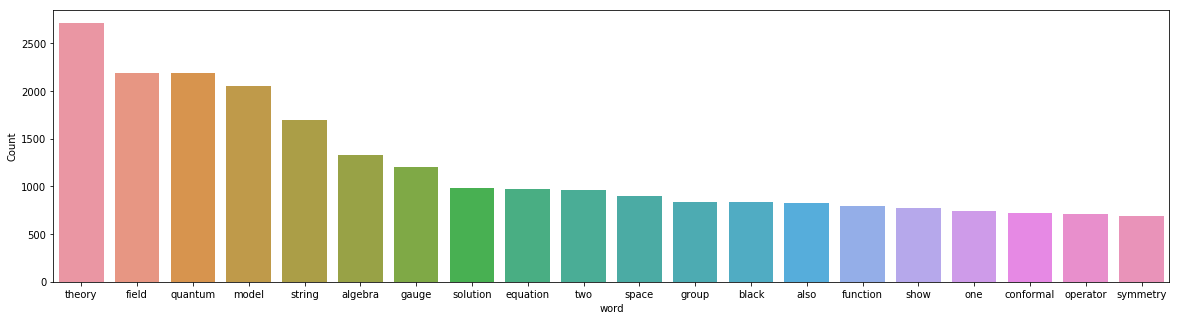

Most frequent words:            word  count
12      theory   2712
82       field   2190
49     quantum   2188
208      model   2048
108     string   1694
56     algebra   1331
348      gauge   1205
239   solution    984
35    equation    972
402        two    958
14       space    902
2        group    839
530      black    838
177       also    828
10    function    791
644       show    777
395        one    737
750  conformal    721
141   operator    710
59    symmetry    687
Sample of tokenised text:  ['combinatorics', 'modular', 'group', 'ii:', 'kontsevich', 'integral', 'study', 'algebraic', 'aspect', 'kontsevich', 'integral', 'generating', 'function', 'intersection', 'theory', 'modulus', 'space', 'review', 'derivation', 'virasoro', 'kdv', 'constraints.', 'intersection', 'number', 'kontsevich', 'integral', '2.1.', 'main', 'theorem', '2.2', 'expansion', 'character', 'schur', 'function', '2.3', 'proof', 'first', 'part', 'theorem', 'grassmannians', 'kdv', 'matrix', 'airy', 'equation'

/home/ajmc/.virtualenvs/dmsn-graphs/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Saved output LDA visualisation in lda_1991-01-01_1993-12-31.html
Period 1994-01-01 to 1995-12-31
Total papers to process 4679 in period


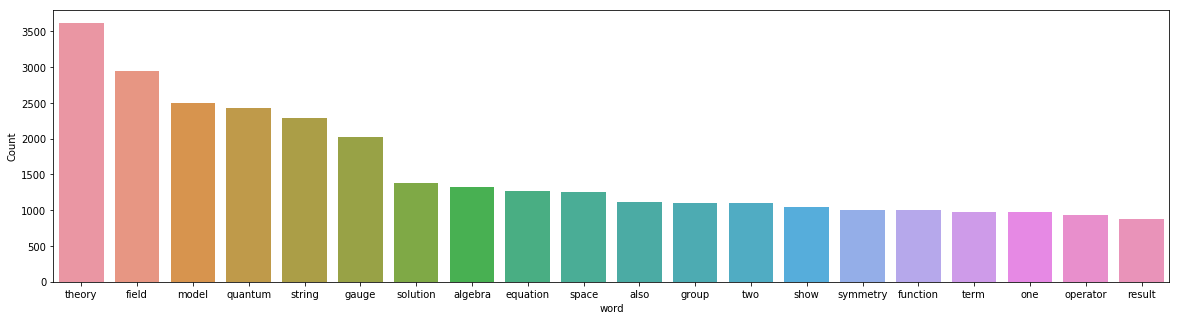

Most frequent words:           word  count
5      theory   3616
4       field   2949
14      model   2493
56    quantum   2432
355    string   2292
79      gauge   2027
424  solution   1383
264   algebra   1328
90   equation   1263
219     space   1255
26       also   1109
284     group   1097
679       two   1096
84       show   1042
251  symmetry   1005
980  function   1001
527      term    975
335       one    970
41   operator    937
180    result    881
Sample of tokenised text:  ['knot', 'invariant', 'rational', 'conformal', 'field', 'theory', 'framework', 'studying', 'knot', 'link', 'invariant', 'rational', 'conformal', 'field', 'theory', 'developed.', 'particular,', 'minimal', 'models,', 'superconformal', 'model', '$w_n$', 'model', 'studied.', 'invariant', 'related', 'invariant', 'obtained', 'wess-zumino', 'model', 'associated', 'coset', 'representation', 'models.', 'possible', 'chern-simons', 'representation', 'model', 'also', 'indicated.', 'generalises', 'earlier', 'work', 'k

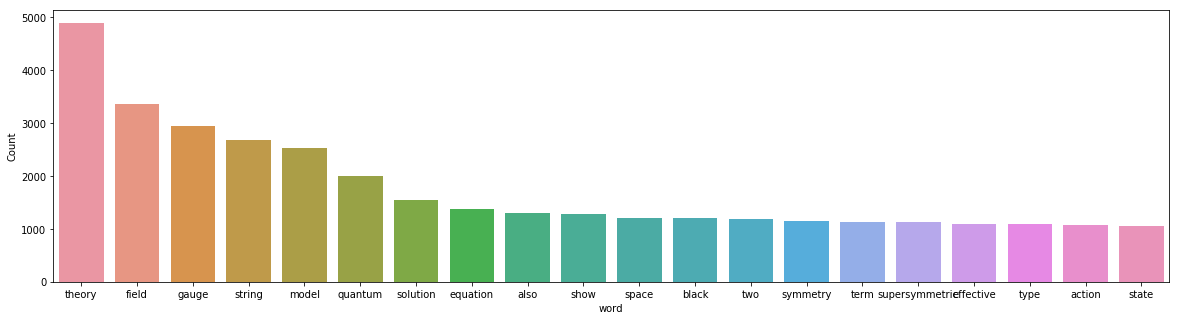

Most frequent words:                 word  count
95           theory   4888
83            field   3364
157           gauge   2949
45           string   2675
316           model   2523
13          quantum   2000
129        solution   1540
308        equation   1373
85             also   1297
158            show   1280
113           space   1213
123           black   1210
64              two   1182
37         symmetry   1148
27             term   1136
291  supersymmetric   1125
88        effective   1091
62             type   1087
63           action   1064
327           state   1045
Sample of tokenised text:  ['integrable', 'z_n-chiral', 'potts', 'model:', 'missing', 'rapidity-momentum', 'mccoy-roan', 'integral', 'representation', 'gap', 'integrable', 'z_n-', 'symmetric', 'chiral', 'potts', 'quantum', 'chain', 'used', 'calculate', 'boundary', 'incommensurable', 'phase', 'various', 'limit', '\\infty', 'analytic', 'formula', 'phase', 'boundary', 'obtained.', 'mccoy-roan', 'formula', 'give

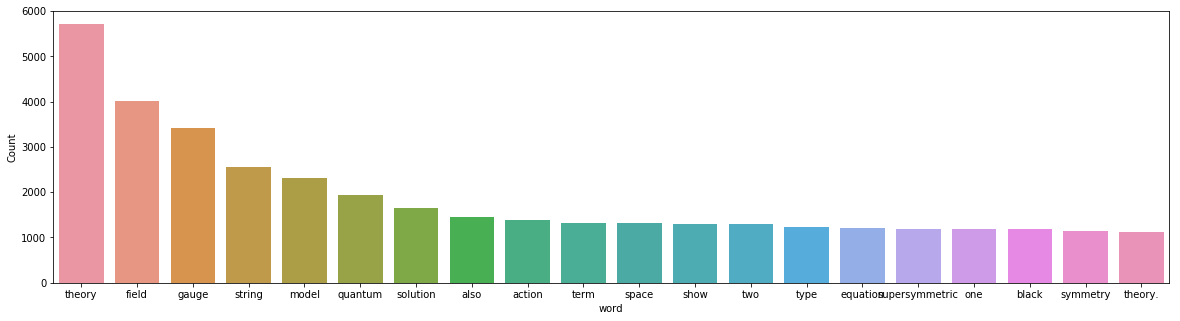

Most frequent words:                 word  count
52           theory   5714
3             field   4005
43            gauge   3428
288          string   2546
11            model   2314
160         quantum   1949
423        solution   1661
224            also   1462
351          action   1379
112            term   1317
263           space   1310
405            show   1303
424             two   1291
336            type   1233
399        equation   1218
42   supersymmetric   1198
163             one   1184
605           black   1184
866        symmetry   1139
704         theory.   1117
Sample of tokenised text:  ['forced', 'topological', 'nontrivial', 'field', 'configurations', 'motion', 'one-dimensional', 'kink', 'energy', 'loss', 'considered', 'model', 'interaction', 'nontrivial', 'topological', 'field', 'configuration', 'external', 'fields.', 'approach', 'based', 'calculation', 'zero', 'mode', 'excitation', 'probability', 'external', 'field.', 'study', 'way', 'interaction', "t'hooft-pol

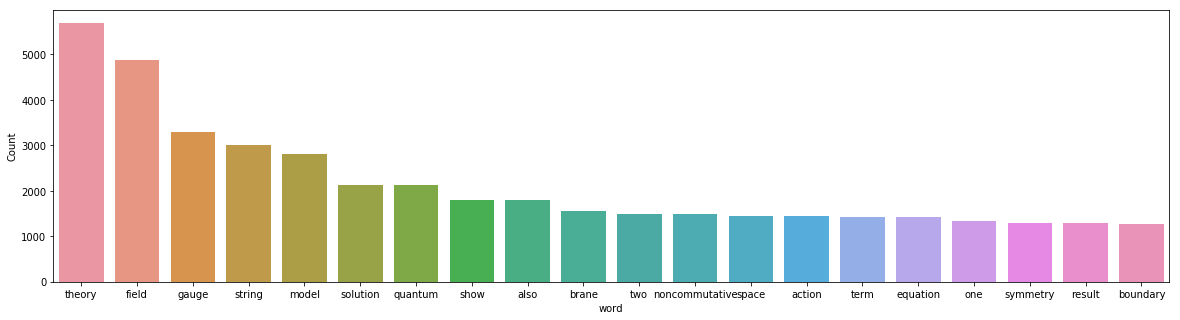

Most frequent words:                 word  count
12           theory   5691
177           field   4869
352           gauge   3301
23           string   3009
199           model   2814
73         solution   2138
176         quantum   2128
185            show   1800
117            also   1798
130           brane   1558
564             two   1495
409  noncommutative   1486
11            space   1455
397          action   1455
426            term   1425
479        equation   1424
76              one   1339
238        symmetry   1295
104          result   1282
101        boundary   1268
Sample of tokenised text:  ['compactification,', 'geometry', 'duality:', 'n=2', 'note', 'based', 'lecture', 'given', 'tasi99.', 'review', 'geometry', 'modulus', 'space', 'n=2', 'theory', 'four', 'dimension', 'point', 'view', 'superstring', 'compactification.', 'case', 'type', 'iia', 'type', 'iib', 'string', 'compactified', 'calabi-yau', 'threefold', 'heterotic', 'string', 'compactified', 'k3xt2', 'considered

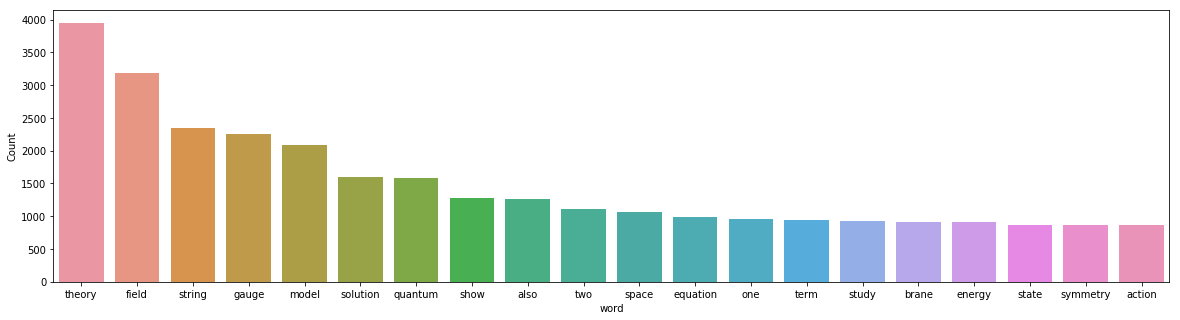

Most frequent words:           word  count
17     theory   3948
83      field   3178
163    string   2351
103     gauge   2253
149     model   2087
285  solution   1596
11    quantum   1585
119      show   1281
107      also   1260
213       two   1115
94      space   1068
34   equation    992
38        one    964
171      term    947
183     study    930
109     brane    915
121    energy    908
236     state    869
748  symmetry    869
176    action    863
Sample of tokenised text:  ['integrable', 'heisenberg-van', 'vleck', 'chain', 'variable', 'range', 'exchange', 'review', 'recent', 'result', 's=1/2', 'quantum', 'spin', 'chain', '$1/\\sinh^2(\\kappa', 'exchange', 'presented.', 'related', 'problem', 'theory', 'classical', 'quantum', 'calogero-sutherland-moser', 'system', 'inverse', 'square', 'hyperbolic', 'elliptic', 'potential', 'discussed.', 'attention', 'paid', 'finding', 'explicit', 'form', 'corresponding', 'bethe-ansatz', 'equation', 'connection', 'generalized', 'hubbard', 'cha

In [9]:
for period in periods:
    start_date = period['start_date']
    end_date = period['end_date']

    print(f'Period {start_date} to {end_date}')
    
    papers_in_period = df[((start_date <= df['date']) & (df['date'] <= end_date))]

    print(f'Total papers to process {papers_in_period.shape[0]} in period')

    text_in_period = list(papers_in_period.text)
    texts = preprocess_texts(text_in_period)
    
    print("Most frequent words: ", freq_words(texts, 20))

    tokenized_text = [x.split() for x in texts]
    print("Sample of tokenised text: ", tokenized_text[0], tokenized_text[1])

    dictionary = corpora.Dictionary(tokenized_text)
    doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_text]

    # Creating the object for LDA model using gensim library
    LDA = gensim.models.ldamodel.LdaModel

    # Build LDA model
    lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=3, random_state=100,
                    chunksize=1000, passes=10)

    print('LDA topics: ', lda_model.print_topics())

    # Prepare visualisation and output results
    vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
    
    output_lda_visualisation_file = f'lda_{start_date}_{end_date}.html'
    pyLDAvis.save_html(vis, output_lda_visualisation_file)
    
    print(f'Saved output LDA visualisation in {output_lda_visualisation_file}')

    print('========================')